In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import joblib
import torch


from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split
import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image 
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_hub as hub 
from sklearn.metrics import balanced_accuracy_score


## 1. train test split

In [2]:
import joblib
x = joblib.load("/kaggle/input/preprocessing-done/x_data.joblib")
y = joblib.load("/kaggle/input/preprocessing-done/y_data.joblib")
img_ids = joblib.load("/kaggle/input/preprocessing-done/img_ids.joblib")
print(x.shape)
print(y.shape)


(10763, 256, 256, 3)
(10763,)


In [3]:
from sklearn.model_selection import train_test_split
x1=x[:7500]
y1=y[:7500]
img_ids1=img_ids[:7500]
x_train, x_test, y_train, y_test, img_ids_train, img_ids_test = train_test_split(x1, y1, img_ids1, test_size=0.15, shuffle=True, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(6375, 256, 256, 3)
(1125, 256, 256, 3)
(6375,)
(1125,)


In [4]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

def balanced_accuracy(y_true, y_pred):
    y_pred_classes = tf.argmax(y_pred, axis=1)
    C = tf.math.confusion_matrix(y_true, y_pred_classes)
    per_class = tf.linalg.diag_part(C) / tf.reduce_sum(C, axis=1)
    balanced_acc = tf.reduce_mean(per_class)
    return balanced_acc


## 2. using pretrained efficientNet model

In [5]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import numpy as np

In [6]:
# Assuming you have already loaded x_train, y_train, x_test, y_test
#from tensorflow.keras.metrics import accuracy
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Loading the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

# Unfreeze some of the later layers
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Adding custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)  # Adding dropout
x = Dense(512, activation='relu')(x)
x = Dropout(0.1)(x)  # Adding dropout
predictions = Dense(6, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Manually calculate class weights based on class distribution
num_classes = 6
class_weights = {}
total_samples = len(y_train)

# Set a small non-zero value for classes with no samples
epsilon = 1e-10

for c in range(num_classes):
    class_count = len(y_train[y_train == c])
    if class_count == 0:
        class_weights[c] = epsilon  # Avoid division by zero
    else:
        class_weights[c] = total_samples / ((num_classes * class_count) + epsilon)

# Implement a learning rate schedule
def learning_rate_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9

# Compile the model with manually calculated class weights and custom learning rate
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']  # Add Balanced Accuracy as a metric
)

# Augmenting training data
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=None  
)

datagen.fit(x_train)

# Fine-tune the model with dropout layers
history = model.fit(datagen.flow(x_train, y_train, batch_size=64), 
                    validation_data=(x_test, y_test),
                    steps_per_epoch=len(x_train) // 64, 
                    epochs=10, 
                    class_weight=class_weights,
                    callbacks=[LearningRateScheduler(learning_rate_scheduler), 
                               EarlyStopping(patience=5, restore_best_weights=True)])

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print(f'Validation Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


16705208/16705208 [==============================] - 0s 0us/step
Epoch 1/10


2023-11-28 10:46:18.512194: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


99/99 [==============================] - 150s 976ms/step - loss: 1.2231 - accuracy: 0.3759 - val_loss: 1.7524 - val_accuracy: 0.1476 - lr: 1.0000e-04
Epoch 2/10
99/99 [==============================] - 95s 954ms/step - loss: 1.0035 - accuracy: 0.5032 - val_loss: 1.6588 - val_accuracy: 0.1680 - lr: 1.0000e-04
Epoch 3/10
99/99 [==============================] - 96s 964ms/step - loss: 0.8888 - accuracy: 0.5557 - val_loss: 1.7004 - val_accuracy: 0.2302 - lr: 1.0000e-04
Epoch 4/10
99/99 [==============================] - 95s 953ms/step - loss: 0.8088 - accuracy: 0.5948 - val_loss: 1.5248 - val_accuracy: 0.2978 - lr: 1.0000e-04
Epoch 5/10
99/99 [==============================] - 94s 941ms/step - loss: 0.7440 - accuracy: 0.6257 - val_loss: 1.3612 - val_accuracy: 0.4116 - lr: 1.0000e-04
Epoch 6/10
99/99 [==============================] - 95s 951ms/step - loss: 0.6840 - accuracy: 0.6585 - val_loss: 1.5095 - val_accuracy: 0.3973 - lr: 9.0000e-05
Epoch 7/10
99/99 [==============================] 

In [7]:
loss, accuracy= model.evaluate(x_test, y_test)
print(f'Validation Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


36/36 [==============================] - 3s 79ms/step - loss: 1.3176 - accuracy: 0.4764
Validation Loss: 1.3176, Accuracy: 0.4764


In [8]:
from tensorflow.keras.models import save_model
save_model(model, "/kaggle/working/efficient-net-model.h5")
#model.save('/kaggle/working/efficient-net-model.h5')

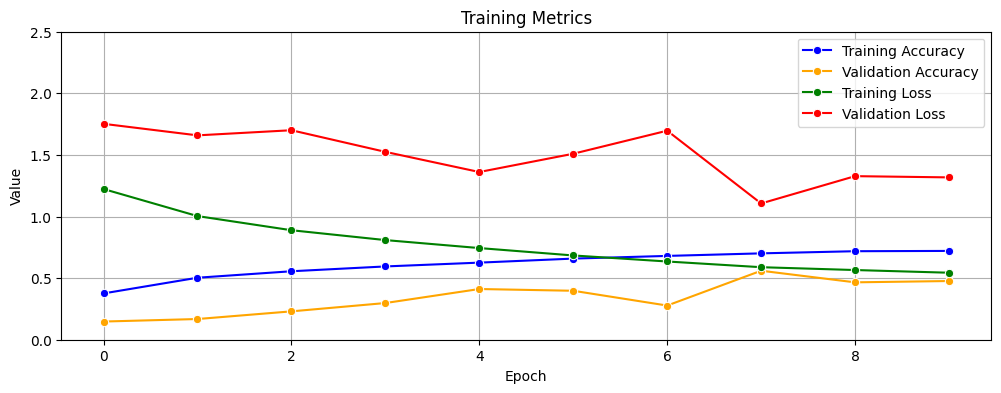

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract metrics from the training history
history_metrics = history.history

# Convert metrics to a DataFrame
metrics_df = pd.DataFrame(history_metrics)

# Plot the metrics using seaborn with different colors
plt.figure(figsize=(12, 4))
sns.lineplot(data=metrics_df['accuracy'], marker='o', label='Training Accuracy', color='blue')
sns.lineplot(data=metrics_df['val_accuracy'], marker='o', label='Validation Accuracy', color='orange')
sns.lineplot(data=metrics_df['loss'], marker='o', label='Training Loss', color='green')
sns.lineplot(data=metrics_df['val_loss'], marker='o', label='Validation Loss', color='red')
plt.ylim(0, 2.50)
plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
predictions= model.predict(x_test)
y_pred = np.argmax(predictions, axis=1)

36/36 [==============================] - 4s 77ms/step


In [11]:
from collections import Counter
from sklearn.metrics import accuracy_score
def find_majority_label(image_ids, labels):
    id_label_map = {}  # 创建一个空的字典来存储image_id和对应的label

    # 遍历image_ids和labels列表
    for image_id, label in zip(image_ids, labels):
        if image_id in id_label_map:
            id_label_map[image_id].append(label)
        else:
            id_label_map[image_id] = [label]

    majority_labels = {}  # 创建一个空的字典来存储每个唯一image_id的多数投票label

    # 对字典中的每个唯一image_id的label列表进行多数投票
    for image_id, label_list in id_label_map.items():
        label_counts = Counter(label_list)
        majority_label = label_counts.most_common(1)[0][0]
        majority_labels[image_id] = majority_label

    return majority_labels

y_votingpred=find_majority_label(img_ids_test, y_pred)
# 对图像 ID 进行去重
unique_img_ids = np.unique(img_ids_test)

# 根据去重后的图像 ID，获取对应的真实标签和预测标签
y_test_matched = []
y_test_matched = np.array([y_test[np.where(img_ids_test == img_id)[0][0]] for img_id in unique_img_ids])
y_votingpred_matched = np.array([y_votingpred[img_id] for img_id in unique_img_ids])

# 计算准确度
accuracy = accuracy_score(y_test_matched, y_votingpred_matched)
print("accuracy:", accuracy)# 计算准确度

accuracy: 0.48195876288659795


In [12]:
from sklearn.metrics import balanced_accuracy_score

# 计算平衡准确率
balanced_acc = balanced_accuracy_score(y_test_matched, y_votingpred_matched)

print("balanced_acc:", balanced_acc)

balanced_acc: 0.5296356597541827
